In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv("../content/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("../content/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("../content/test.csv", parse_dates=["date"])

In [2]:
# Lựa chọn đặc trưng và target
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

In [3]:
# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [4]:
# Dataset & Dataloader
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SalesDataset(X_train, y_train)
valid_dataset = SalesDataset(X_valid, y_valid)
test_dataset = SalesDataset(X_test, y_test)

In [5]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [15]:
# Xây dựng mô hình GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(30, len(features))))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    callbacks=[early_stop]
)

Epoch 1/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.4762e-04
Epoch 2/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3902e-04
Epoch 3/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.2815e-04
Epoch 4/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.2782e-04
Epoch 5/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.0167e-04
Epoch 6/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0602e-04
Epoch 7/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 7.4129e-05
Epoch 8/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.5124e-05
Epoch 9/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.0118e-05
Epoch 10/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.3578e-05
Epoch 11/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3.5906e-05
Epoch 12/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 2.5184e-05
Epoch 13/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.3750e-05
Epoch 14/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━

In [16]:
# Đánh giá mô hình
def evaluate_keras(model, X, y, scaler_y, name="Test"):
    preds = model.predict(X, batch_size=64)
    preds = scaler_y.inverse_transform(preds).flatten()
    targets = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(targets, preds)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")
    return preds, targets

# Gọi hàm đánh giá cho mô hình Keras
test_preds, test_targets = evaluate_keras(model, X_test, y_test, scaler_y)

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test - MAE: 1410633.60, MSE: 5226706483308.15, R2: 1.00


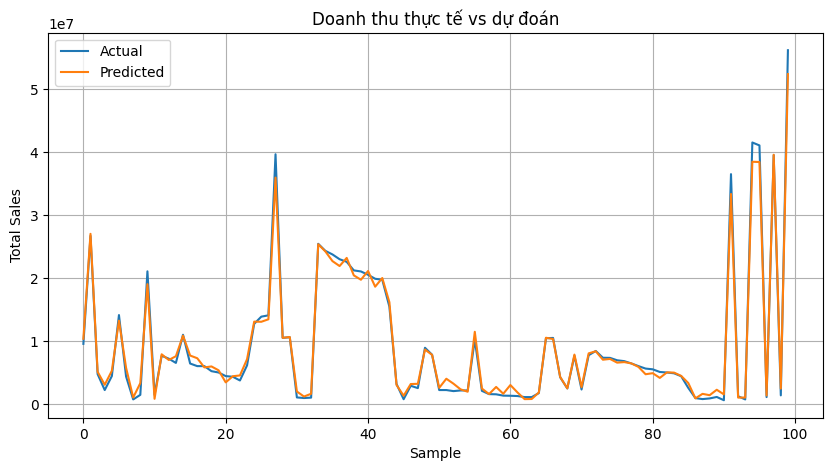

In [18]:
# So sánh doanh thu thực tế với dự đoán
plt.figure(figsize=(10,5))
plt.plot(test_targets[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [19]:
df_model = pd.concat([train_df, valid_df, test_df], ignore_index=True)

X_scaled = scaler_X.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[[target]])

In [20]:
# Dự đoán 30 ngày tiếp theo từ điểm cuối của test
last_sequence_input = X_scaled[-30:].reshape(1, 30, len(features))
future_preds = []

for _ in range(30):
    next_pred = model.predict(last_sequence_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_sequence_input = np.append(last_sequence_input[:,1:,:], [[X_scaled[-1]]], axis=1)

future_preds_real = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_date = df_model['date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

In [21]:
# Tạo DataFrame chứa dự đoán
future_preds_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_preds_real.flatten(),
    'type': 'Forecasted Sales'
})
print(future_preds_df)

         date   total_sales              type
0  2018-12-11 -5.910855e+07  Forecasted Sales
1  2018-12-12 -2.922847e+07  Forecasted Sales
2  2018-12-13  3.625410e+06  Forecasted Sales
3  2018-12-14  3.548325e+07  Forecasted Sales
4  2018-12-15  6.437952e+07  Forecasted Sales
5  2018-12-16  8.981076e+07  Forecasted Sales
6  2018-12-17  1.119728e+08  Forecasted Sales
7  2018-12-18  1.309188e+08  Forecasted Sales
8  2018-12-19  1.470104e+08  Forecasted Sales
9  2018-12-20  1.607816e+08  Forecasted Sales
10 2018-12-21  1.723907e+08  Forecasted Sales
11 2018-12-22  1.821593e+08  Forecasted Sales
12 2018-12-23  1.908613e+08  Forecasted Sales
13 2018-12-24  1.979127e+08  Forecasted Sales
14 2018-12-25  2.039757e+08  Forecasted Sales
15 2018-12-26  2.094436e+08  Forecasted Sales
16 2018-12-27  2.134863e+08  Forecasted Sales
17 2018-12-28  2.169958e+08  Forecasted Sales
18 2018-12-29  2.200587e+08  Forecasted Sales
19 2018-12-30  2.227223e+08  Forecasted Sales
20 2018-12-31  2.248781e+08  Forec

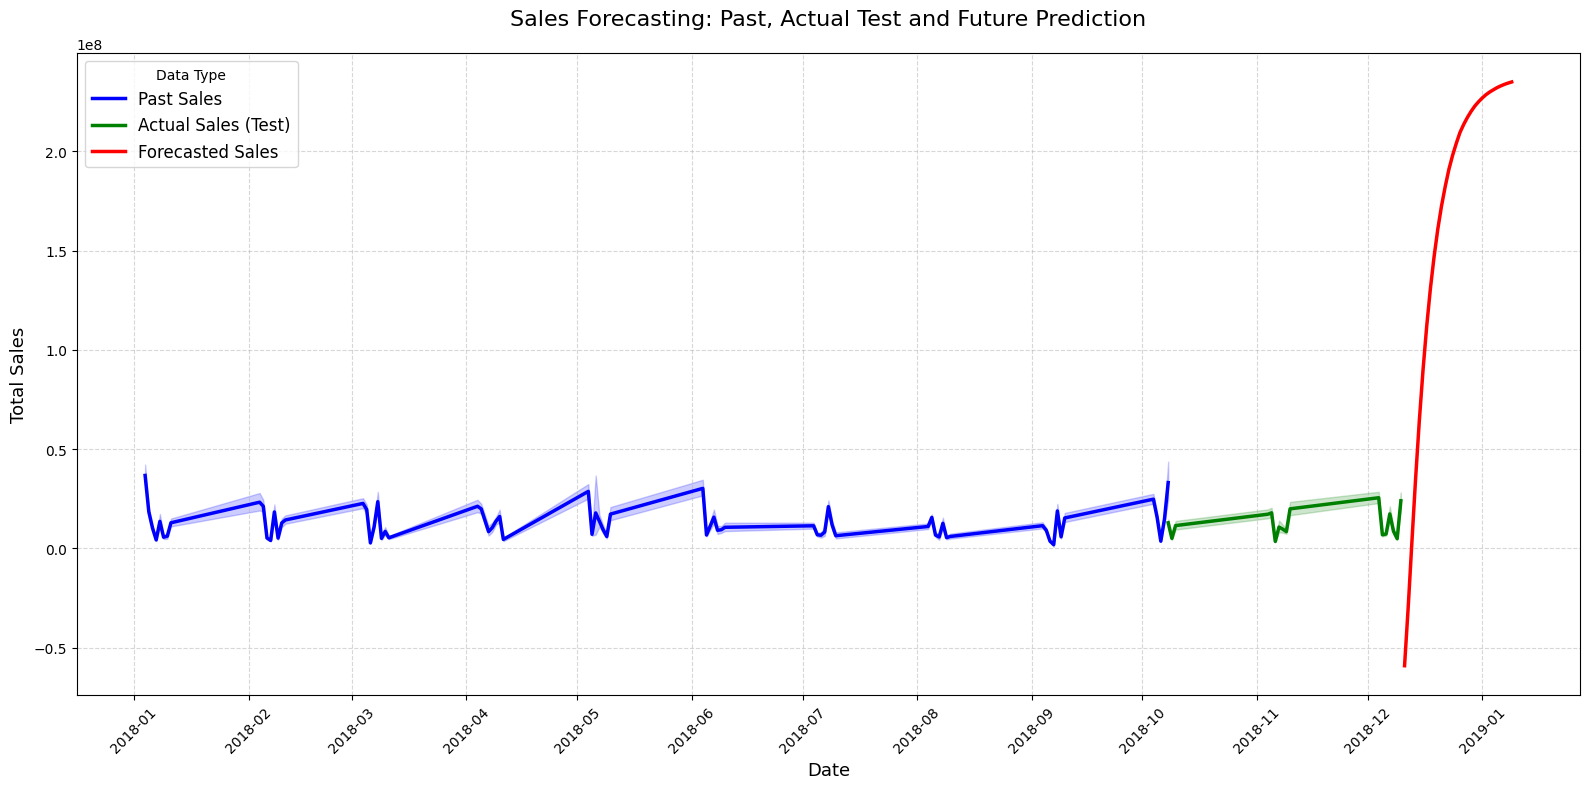

In [22]:
import seaborn as sns
import matplotlib.dates as mdates

# Vẽ biểu đồ
# Chuẩn bị dữ liệu quá khứ để visualization
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'  # Thêm thông tin cho test data

# Gộp tất cả dữ liệu
combined_df = pd.concat([
    train_df[['date', 'total_sales', 'type']],
    valid_df[['date', 'total_sales', 'type']],
    test_df[['date', 'total_sales', 'type']],
    future_preds_df
], ignore_index=True)

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Thêm các chi tiết cho đồ thị
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()